In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Connecting to DB
con = duckdb.connect("../github_stars.db")

In [4]:
query = """
    SELECT s.date_day, s.repo_id, r.repo_name, s.count_stars
    FROM github_stars.main.fact_stars_monthly as s
    JOIN github_stars.main.dim_repos as r
    ON s.repo_id = r.repo_id
    AND end_date IS NULL
"""

df_monthly_stars = con.sql(query).df()
df_monthly_stars.to_csv("monthly_stars.csv")

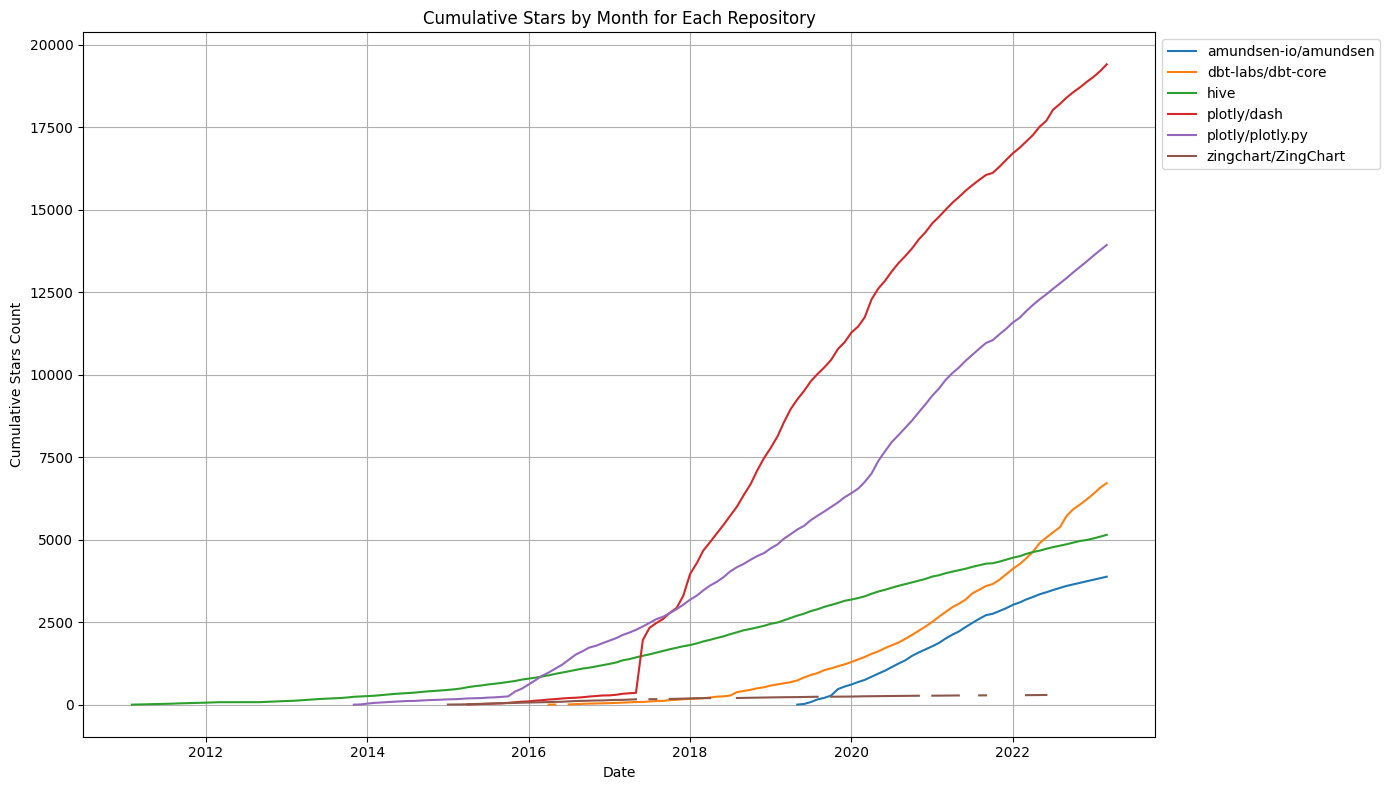

In [5]:
# Convert date_day to datetime format
data = pd.read_csv("monthly_stars.csv")
data['date_day'] = pd.to_datetime(data['date_day'])

# Drop the unnamed column
data = data.drop(columns=['Unnamed: 0'])

# Convert date_day to datetime
data['date_day'] = pd.to_datetime(data['date_day'])

# Group data by repo_name and date_day, then sum the stars count
grouped_data = data.groupby(['repo_name', 'date_day']).sum().reset_index()

# Calculate cumulative stars for each repo
grouped_data['cumulative_stars'] = grouped_data.groupby('repo_name')['count_stars'].cumsum()

# Pivot the table to have repo_names as columns and date_days as rows
cumulative_pivot_table = grouped_data.pivot(index='date_day', columns='repo_name', values='cumulative_stars')

# Plotting the cumulative stars chart
plt.figure(figsize=(14, 8))

for column in cumulative_pivot_table.columns:
    plt.plot(cumulative_pivot_table.index, cumulative_pivot_table[column], label=column)

plt.xlabel('Date')
plt.ylabel('Cumulative Stars Count')
plt.title('Cumulative Stars by Month for Each Repository')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
con.close()